In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from GANmodel import *
from lineardatatools import p_y_zt_from_true_dist, linear_binary_ty_pydot
from matplotlib.lines import Line2D
%load_ext autoreload
%autoreload 2

In [2]:
netG = Generator(3)
netD = Discriminator()
netG.load_state_dict(torch.load("./GANmodels/3dGenerator"))
netD.load_state_dict(torch.load("./GANmodels/3dDiscriminator"))

<All keys matched successfully>

In [3]:
from imagedata import *
from imagedatatools import *

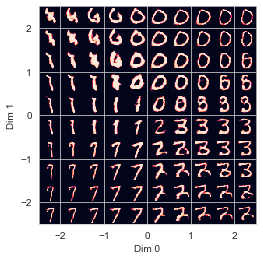

In [4]:
viz_image_space(netG,0,1)

# Generate data sizes to test convergence

In [4]:
generator = netG
c_x = np.array([1])
s_x = np.array([0.5])
t_a = np.array([1])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
datasize = [1000,2000,3000,4000,5000,6000,10000]
param_times = 10

gen_zdim=3

dataparameters = [[num_samples, gen_zdim, generator, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x] for \
                 num_samples in datasize]
param_times = 10

main_folder = "imagedata"
sub_folder_data = "samplesize1000to10000"
data_labels = list(map(str,datasize))

In [34]:
#create_dfs_datasets(generate_image_data, dataparameters, param_times, repeat=False, main_folder=main_folder,
#                    sub_folder=sub_folder_data, labels=data_labels)

Creation of the directory './data/imagedata/samplesize1000to10000/ failed. Trying to empty the same folder.
Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6


({'1000': {0:            z0        z1        z2        x0    t    y
   0    1.813017 -0.234707  2.170038  2.590332  1.0  1.0
   1   -0.285555  0.636904  0.380636  0.012000  1.0  0.0
   2    0.003841  1.515734 -1.213581  0.989098  0.0  1.0
   3    1.786726 -1.583776 -0.071073  1.594187  0.0  1.0
   4   -1.117831 -1.286393 -1.160146 -2.099718  1.0  0.0
   ..        ...       ...       ...       ...  ...  ...
   995  2.876933  1.565876  0.702933  3.788956  1.0  1.0
   996 -0.777825  0.066176  0.995605 -1.003763  0.0  1.0
   997 -1.108610 -0.728323  1.241316 -0.166166  0.0  0.0
   998  0.922799 -1.133190 -0.344590  0.058159  1.0  0.0
   999  0.799122 -0.730804 -1.276311  0.049729  1.0  1.0
   
   [1000 rows x 6 columns],
   1:            z0        z1        z2        x0    t    y
   0    0.458664 -0.876876  1.122603  0.468220  1.0  0.0
   1    0.493046  0.980851 -0.516397  1.031557  1.0  1.0
   2    0.523781  1.493100  0.509746  1.292054  0.0  1.0
   3    0.471524  0.639686  1.404390  0.44

In [5]:
dfs, datasets = load_dfs_datasets(main_folder, sub_folder_data, param_times)

In [6]:
device='cuda'
plot_curves=True

z_dim = 20
x_dim = 1
param_times = 10

p_y_zt_nn=True
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn=True
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn=True
p_x_z_nn_layers=3
p_x_z_nn_width=30

num_epochs = 100
lr_start = 0.005
lr_end = 0.001
image_loss_scaling = 1
train_parameters = [num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn, p_y_zt_nn_layers, p_y_zt_nn_width, 
              p_t_z_nn, p_t_z_nn_layers, p_t_z_nn_width,
              p_x_z_nn, p_x_z_nn_layers, p_x_z_nn_width, image_loss_scaling]

BATCH_SIZE = 100


from lineardatatools import p_y_zt_from_true_dist, linear_binary_ty_pydot
p_y_zt1, p_y_zt0 = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
p_y_dot1_true, p_y_dot0_true = linear_binary_ty_pydot(p_y_zt1, p_y_zt0)

labels = data_labels

track_function = estimate_imageCEVAE_ATE
true_value = (p_y_dot1_true, p_y_dot0_true)
sub_folder_model = "modelsamplesize1000to10000"

In [22]:
run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, BATCH_SIZE, track_function, true_value,
                                  device, train_parameters, labels, data_labels)

Creation of the directory './data/imagedata/modelsamplesize1000to10000/ failed. Trying to empty the same folder.
1


KeyboardInterrupt: 

In [7]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_parameters, labels, device)

In [40]:
py_dot1 = np.zeros((param_times, len(labels)))
py_dot0 = np.zeros((param_times, len(labels)))

for i,label in enumerate(labels):
    print(label)
    for j in range(param_times):
        py_dot = estimate_imageCEVAE_ATE(models[label][j])
        py_dot1[j,i] = py_dot[1]
        py_dot0[j,i] = py_dot[2]

1000
2000
3000
4000
5000
6000
10000


# Run loss scaling tests

In [7]:
num_params = 10
dataset10000 = {"df10000": [datasets['10000'][0] for i in range(num_params)]}

In [26]:
model = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)

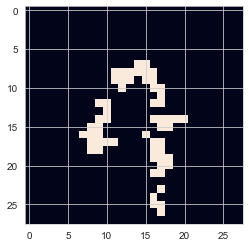

In [57]:
image = next(iter(dataset10000['df10000'][0]))['image'].to(device)


In [7]:
device='cuda'
plot_curves=True

z_dim = 20
x_dim = 1
param_times = 2

p_y_zt_nn=True
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn=True
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn=True
p_x_z_nn_layers=3
p_x_z_nn_width=30

#How to get good values for these?
image_loss_scaling = [1,0.05,0]#[0,0.005,0.01,0.02,0.05,0.1]

num_epochs = 1000#These should be looked at
lr_start = 0.003
lr_end = 0.001
separate_ty = True
train_parameters = [num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn, p_y_zt_nn_layers, p_y_zt_nn_width, 
              p_t_z_nn, p_t_z_nn_layers, p_t_z_nn_width,
              p_x_z_nn, p_x_z_nn_layers, p_x_z_nn_width, image_loss_scaling, separate_ty]

BATCH_SIZE = 1000

data_labels = ["df10000"]*len(image_loss_scaling)
labels = list(map(str,image_loss_scaling))

track_function = estimate_imageCEVAE_ATE
#true_value = (p_y_dot1_true, p_y_dot0_true)
sub_folder_model = "modelsamplesize10000scalings"

Creation of the directory './data/imagedata/modelsamplesize10000scalings/ failed. Trying to empty the same folder.
1
Epoch 0:
Image: 3939.8243408203125, x: 19.91111648082733, t: 6.822701513767242, y: 6.382846236228943
0.2147296667098999 0.6106253266334534 0.39589565992355347
Epoch 20:
Image: 1093.7152557373047, x: 14.053757905960083, t: 2.428049474954605, y: 1.7510577291250229
0.2579036355018616 0.6714009046554565 0.41349726915359497
Epoch 40:
Image: 719.29296875, x: 10.066133558750153, t: 0.9671822637319565, y: 1.7281719744205475
0.3371274769306183 0.7262338995933533 0.389106422662735
Epoch 60:
Image: 636.6327209472656, x: 8.297428667545319, t: 1.6057996302843094, y: 2.25185027718544
0.5787749886512756 0.7614362835884094 0.1826612800359726
Epoch 80:
Image: 604.7741317749023, x: 7.8184351325035095, t: 3.1037341356277466, y: 3.3314985632896423
0.5236162543296814 0.7392513751983643 0.21563510596752167
Epoch 100:
Image: 580.8022651672363, x: 7.608519375324249, t: 3.9143038988113403, y: 3.

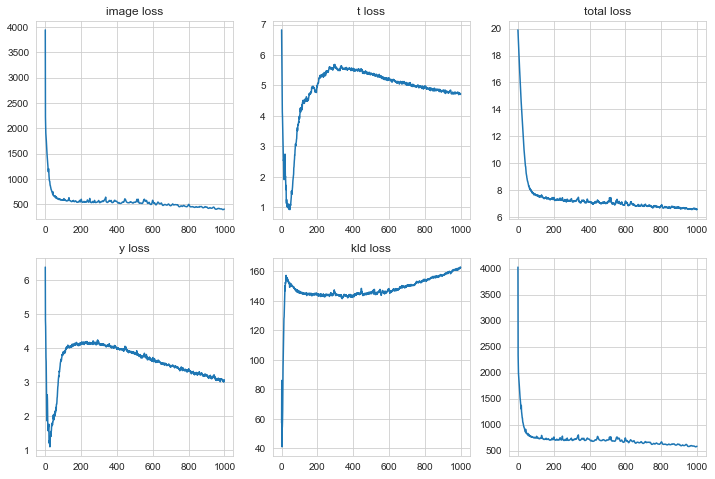

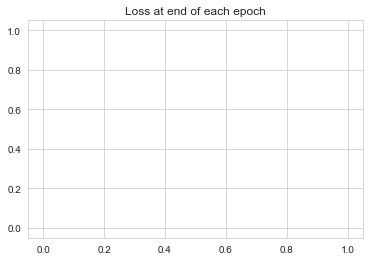

Estimated causal effect: (tensor(0.2048, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.6276, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4228, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)
1
Epoch 0:
Image: 3891.65673828125, x: 19.86820375919342, t: 6.7849127650260925, y: 6.2794798612594604
0.27889135479927063 0.6378292441368103 0.3589378893375397
Epoch 20:
Image: 1032.4821701049805, x: 13.992484092712402, t: 1.183989778161049, y: 0.383609876036644
0.26677992939949036 0.585761308670044 0.3189813792705536
Epoch 40:
Image: 722.3269348144531, x: 10.000462532043457, t: 0.3899638932198286, y: 0.15868244972079992
0.1188192367553711 0.5224460363388062 0.40362679958343506
Epoch 60:
Image: 640.6367874145508, x: 8.110010743141174, t: 0.4285814370959997, y: 0.2880593743175268
0.0309087336063385 0.5053640604019165 0.474455326795578
Epoch 80:
Image: 633.4874038696289, x: 7.7771647572517395, t: 0.44253431260585785, y: 1.95805424451828
0

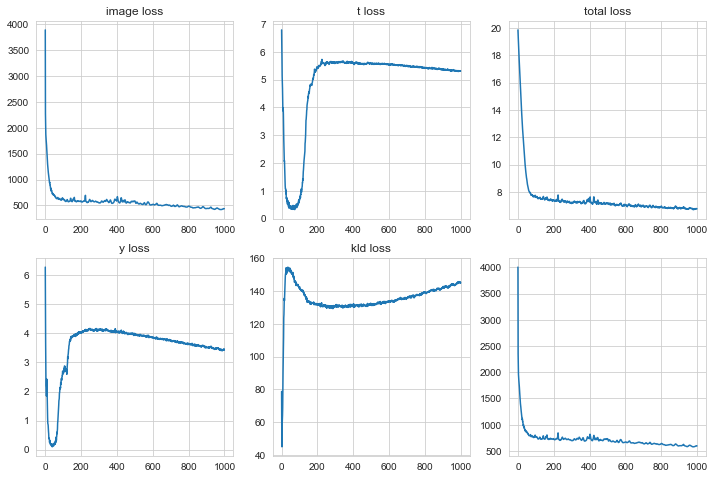

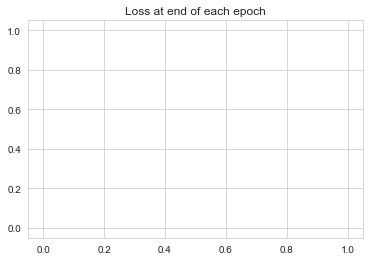

Estimated causal effect: (tensor(0.1550, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.6024, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4473, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)
0.05
Epoch 0:
Image: 195.8883867263794, x: 19.90816366672516, t: 6.776875853538513, y: 6.633899092674255
0.1993776559829712 0.6130484938621521 0.4136708378791809
Epoch 20:
Image: 96.82715129852295, x: 15.599498391151428, t: 6.2070311307907104, y: 5.214508473873138
0.3278522193431854 0.6455368399620056 0.3176846206188202
Epoch 40:
Image: 89.94517040252686, x: 12.639310717582703, t: 5.63186103105545, y: 4.121076911687851
0.18409380316734314 0.5753587484359741 0.391264945268631
Epoch 60:
Image: 84.8450117111206, x: 10.240048050880432, t: 4.269153028726578, y: 3.8363010585308075
0.17532974481582642 0.556810200214386 0.38148045539855957
Epoch 80:
Image: 80.01204919815063, x: 8.38768595457077, t: 5.359841048717499, y: 4.019608050584793
0.17062

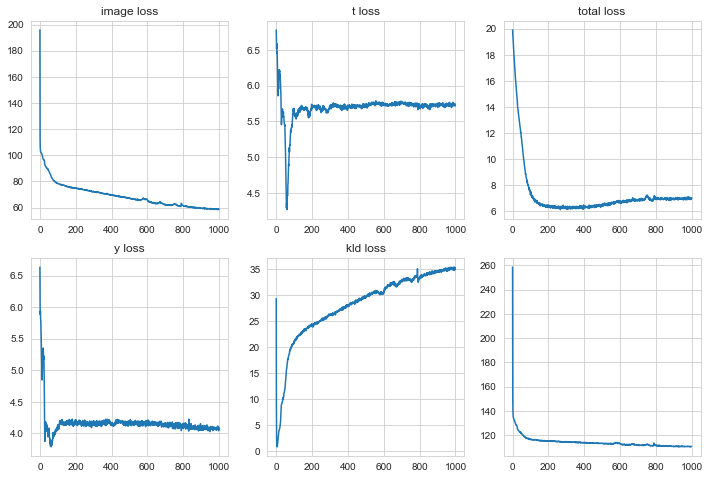

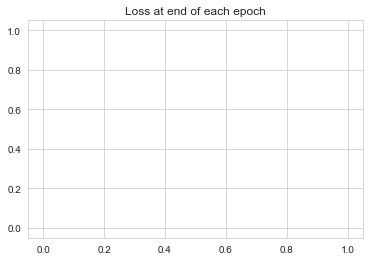

Estimated causal effect: (tensor(0.1537, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.5699, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4162, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)
0.05
Epoch 0:
Image: 201.5164279937744, x: 19.90530025959015, t: 6.810981273651123, y: 6.490059733390808
0.2379426658153534 0.6088857054710388 0.3709430396556854
Epoch 20:
Image: 98.00855350494385, x: 15.560182690620422, t: 6.134255290031433, y: 5.098756641149521
0.312726765871048 0.6495264172554016 0.33679965138435364
Epoch 40:
Image: 188.1812744140625, x: 41.21629452705383, t: 4.965326339006424, y: 3.195555329322815
0.2647913992404938 0.5853977203369141 0.3206063210964203
Epoch 60:
Image: 112.63982677459717, x: 39.821218729019165, t: 2.7147532254457474, y: 0.9569557383656502
0.4677363634109497 0.5302026271820068 0.06246627867221832
Epoch 80:
Image: 104.39371585845947, x: 43.731966733932495, t: 1.3967606723308563, y: 0.8215161189436913


Epoch 980:
Image: 91.26740646362305, x: 15.970808386802673, t: 0.4714982733130455, y: 0.13186910096555948
0.5454650521278381 0.5800949931144714 0.0346299447119236


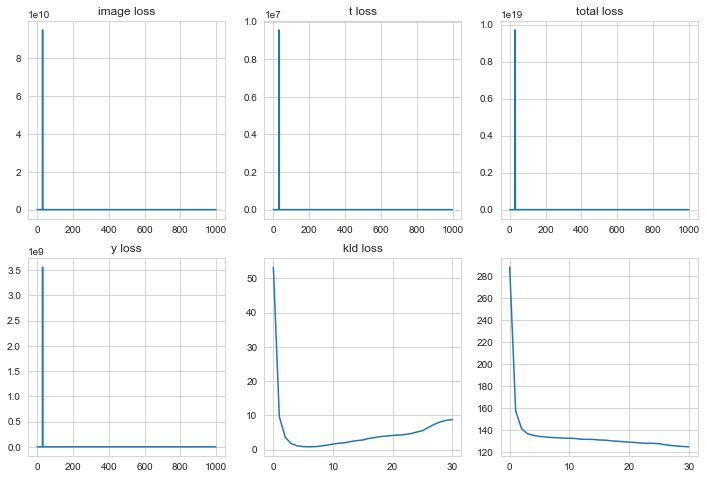

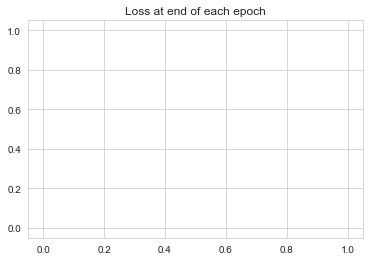

Estimated causal effect: (tensor(0.5298, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.5707, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0410, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)
0
Epoch 0:
Image: 0.0, x: 19.903473019599915, t: 6.617027461528778, y: 6.493614435195923
0.25066080689430237 0.6039838790893555 0.3533230721950531
Epoch 20:
Image: 0.0, x: 16.036697149276733, t: 6.399255752563477, y: 5.5885783433914185
0.3654385805130005 0.6614904403686523 0.29605185985565186
Epoch 40:
Image: 0.0, x: 13.49054229259491, t: 4.973498821258545, y: 3.3253185749053955
0.03900080919265747 0.5273329019546509 0.4883320927619934
Epoch 60:
Image: 0.0, x: 12.283198475837708, t: 5.101594686508179, y: 3.2600084245204926
0.036580681800842285 0.5249846577644348 0.48840397596359253
Epoch 80:
Image: 0.0, x: 11.46713125705719, t: 5.2037962675094604, y: 3.262025684118271
0.07634013891220093 0.5391210913658142 0.4627809524536133
Epoch 100:
I

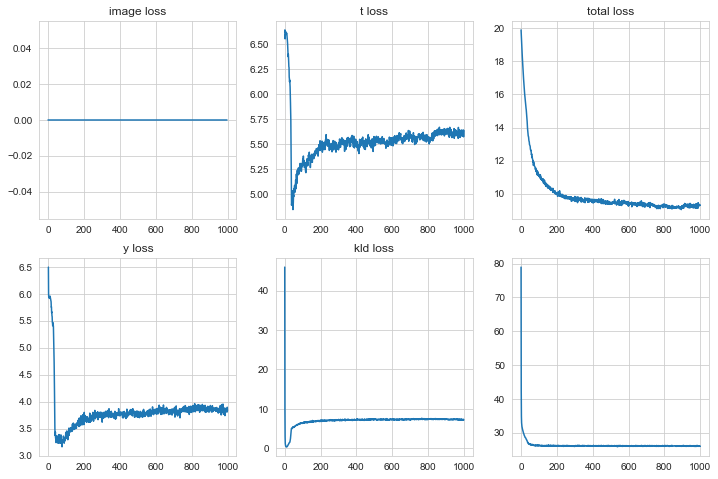

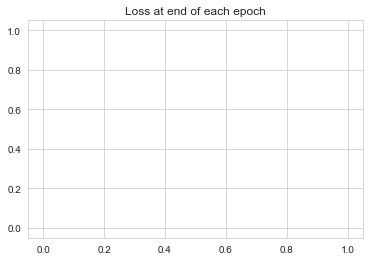

Estimated causal effect: (tensor(0.1182, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.5562, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4380, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)
0
Epoch 0:
Image: 0.0, x: 19.89975357055664, t: 6.691668689250946, y: 6.456378161907196
0.2617241442203522 0.6296940445899963 0.36796990036964417
Epoch 20:
Image: 0.0, x: 16.11245107650757, t: 6.466879427433014, y: 5.863803863525391
0.39461442828178406 0.673863410949707 0.279248982667923
Epoch 40:
Image: 0.0, x: 14.410718202590942, t: 6.128787875175476, y: 4.978759467601776
0.3008166551589966 0.6316599249839783 0.3308432698249817
Epoch 60:
Image: 0.0, x: 12.562383890151978, t: 4.908982545137405, y: 3.3411955535411835
0.057143062353134155 0.5377231240272522 0.48058006167411804
Epoch 80:
Image: 0.0, x: 11.743855476379395, t: 5.14053401350975, y: 3.302738130092621
0.059445589780807495 0.5348501801490784 0.4754045903682709
Epoch 100:
Image: 

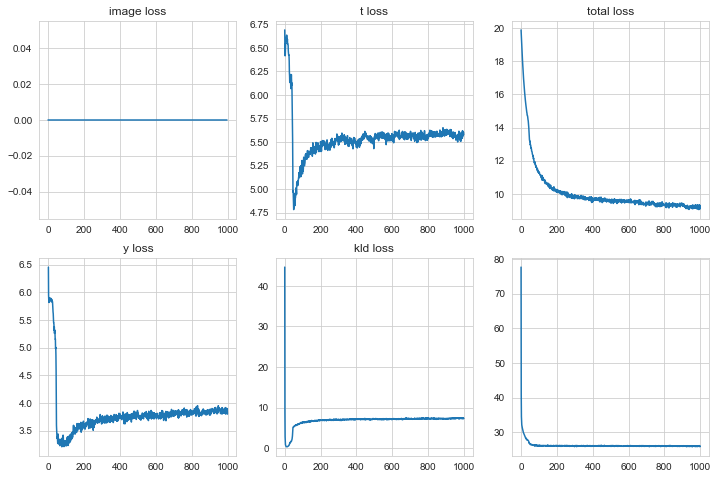

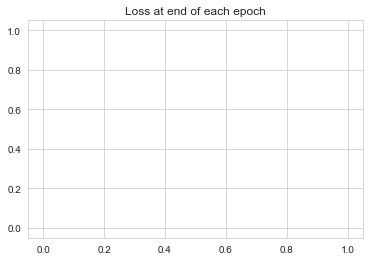

Estimated causal effect: (tensor(0.1209, device='cuda:0', grad_fn=<SubBackward0>), tensor(0.5609, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4400, device='cuda:0', grad_fn=<MeanBackward0>)) true value: (0.5752425317376335, 0.42475746826236643)


({'1': {0: ImageCEVAE(
     (encoder): Encoder(
       (c1): Sequential(
         (0): Conv2d(1, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
         (1): ELU(alpha=1.0)
       )
       (c2): Sequential(
         (0): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
         (1): ELU(alpha=1.0)
       )
       (c3): Sequential(
         (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
         (1): ELU(alpha=1.0)
       )
       (c4): Sequential(
         (0): Conv2d(256, 40, kernel_size=(3, 3), stride=(1, 1), bias=False)
         (1): ELU(alpha=1.0)
       )
       (fc): Sequential(
         (0): Linear(in_features=43, out_features=25, bias=True)
         (1): ELU(alpha=1.0)
       )
       (fc00): Sequential(
         (0): Linear(in_features=41, out_features=25, bias=True)
         (1): ELU(alpha=1.0)
       )
       (fc01): Sequential(
         (0): Linear(in_features=41, out_features=25, bias=T

In [25]:
run_model_for_predef_datasets(dataset10000, param_times, main_folder, sub_folder_model, BATCH_SIZE, track_function, true_value,
                                  device, train_parameters, labels, data_labels)

In [8]:
models_scaling, losses_scaling = load_models_losses(main_folder, sub_folder_model, train_parameters, labels, device)
pydot1s, pydot0s = load_pydots(main_folder, sub_folder_model, labels, device)

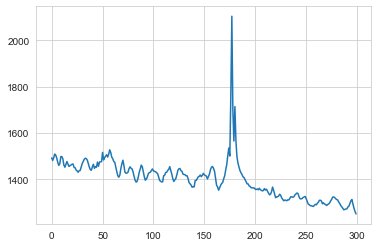

In [178]:
plt.plot(losses['1'][0]['total'][200:])

In [150]:
track_function(models['1'][0])

(tensor(-0.0924, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.5519, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6443, device='cuda:0', grad_fn=<MeanBackward0>))

In [166]:
x

tensor([-2.5006], device='cuda:0')

In [173]:
#Not nearly all dimensions are in use
z_stds = 0
for i in range(100):
    data = datasets['10000'][0][0]
    image, x, t, y = data['image'][None,:,:,:].to(device), data['X'].to(device), data['t'].to(device), data['y'].to(device)
    z_mean, z_std = models['1'][0].encoder(image, x[:,None], t[:,None], y[:,None])
    z_stds += z_std
z_stds/100

tensor([[0.3516, 0.9896, 0.1206, 0.9914, 0.1117, 0.0633, 0.9834, 0.9824, 0.0511,
         1.0051, 0.1588, 0.9802, 1.0026, 1.0009, 0.9673, 0.9932, 1.0168, 0.9958,
         1.0179, 0.1066]], device='cuda:0', grad_fn=<DivBackward0>)

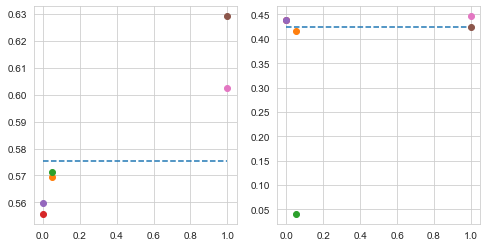

In [32]:
p_y_zt1, p_y_zt0 = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
p_y_dot1_true, p_y_dot0_true = linear_binary_ty_pydot(p_y_zt1, p_y_zt0)

pydot1_scaling = np.zeros((param_times, len(models_scaling.keys())))
pydot0_scaling = np.zeros((param_times, len(models_scaling.keys())))
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot([0,1],[p_y_dot1_true,p_y_dot1_true],'--')
ax[1].plot([0,1],[p_y_dot0_true,p_y_dot0_true],'--')
for i,label in enumerate(models_scaling.keys()):
    for j in models_scaling[label].keys():
        py_dot = [a.detach().item() for a in estimate_imageCEVAE_ATE(models_scaling[label][j])]
        ax[0].plot(float(label), py_dot[1],'o')
        ax[1].plot(float(label), py_dot[2],'o')

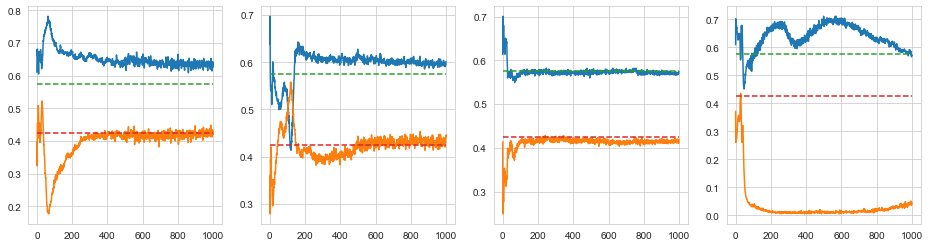

In [90]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
ax[0].plot(pydot1s['1'][1]['1'][0])
ax[0].plot(pydot0s['1'][1]['1'][0])
ax[1].plot(pydot1s['0.05'][0]['1'][1])
ax[1].plot(pydot0s['0.05'][0]['1'][1])
ax[2].plot(pydot1s['0.05'][1]['0.05'][0])
ax[2].plot(pydot0s['0.05'][1]['0.05'][0])
ax[3].plot(pydot1s['0'][1]['0.05'][1])
ax[3].plot(pydot0s['0'][1]['0.05'][1])
for i in range(4):
    ax[i].plot([0,1000],[p_y_dot1_true,p_y_dot1_true],'--')
    ax[i].plot([0,1000],[p_y_dot0_true,p_y_dot0_true],'--')

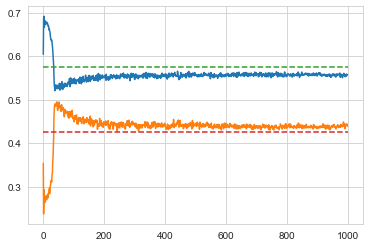

In [98]:
plt.plot(pydot1s['0'][1]['0'][0])
plt.plot(pydot0s['0'][1]['0'][0])
plt.plot([0,1000],[p_y_dot1_true,p_y_dot1_true],'--')
plt.plot([0,1000],[p_y_dot0_true,p_y_dot0_true],'--')

## Investigate the asymptotic estimates and what happens when we change parameters

In [9]:
c_x = np.array([1])
s_x = np.array([0.5])
t_a = np.array([1])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
z, images, x, t, y, dataset = generate_image_data(10000, gen_zdim, generator, 
                                            t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, 2*s_x)
df = pd.DataFrame(torch.cat([z,x,t,y],1).detach().numpy().squeeze(),
                  columns=["z"+str(i) for i in range(z.shape[1])] + ["x0","t","y"])

In [159]:
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression().fit(df[['x0']][df['t']==1], df['y'][df['t']==1])
lr0 = LogisticRegression().fit(df[['x0']][df['t']==0], df['y'][df['t']==0])
z = np.random.randn(20000,1)
print(lr1.predict_proba(z)[:,1].mean())
print(lr0.predict_proba(z)[:,1].mean())
print(df['y'][df['t']==1].mean())
print(df['y'][df['t']==0].mean())
p_y_zt1_, p_y_zt0_ = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
print(linear_binary_ty_pydot(p_y_zt1, p_y_zt0))

0.6490904359601993
0.32917894295419775
0.6821137
0.27593103
(0.5752425317376335, 0.42475746826236643)


Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95


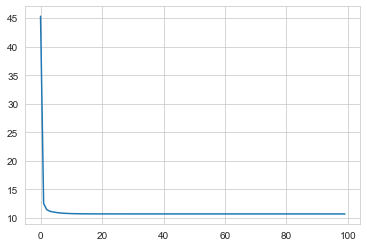

In [10]:
#Total direct fit
model = trainconvynet(device='cuda', num_epochs=100, dataset=dataset, BATCH_SIZE=500, lr_start=0.005, lr_end=0.001)

In [11]:
dataloader = DataLoader(dataset, batch_size=100)
ypred1 = 0
ypred0 = 0
torch.cuda.empty_cache()
def process_batch(batch,ypred1,ypred0):
    image = batch['image'].to('cuda')
    x = batch['X'].to('cuda')
    ypred1 += torch.sigmoid(model(image,x,torch.ones(x.shape[0],1).to(device))).sum().item()
    ypred0 += torch.sigmoid(model(image,x,torch.zeros(x.shape[0],1).to(device))).sum().item()
    del batch, image, x
    torch.cuda.empty_cache()
    return  ypred1, ypred0

for batch in dataloader:
    ypred1,ypred0 = process_batch(batch,ypred1,ypred0)
    
print(ypred1 / 10000, ypred0 / 10000)

0.6326079032897949 0.3434494106292725


0.6101937842247247

In [69]:
import matplotlib as mpl
mpl.style.use('default')

## Try to get likely direct fit value

In [147]:
#Try to get the direct fit value
#z, images, x, t, y, bigdataset = generate_image_data(5000, 3, netG, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x)
datasets['10000']

{0: <imagedata.ImageDataset at 0x1dc17d35ec8>,
 1: <imagedata.ImageDataset at 0x1dc17d35488>,
 2: <imagedata.ImageDataset at 0x1dc17d35148>,
 3: <imagedata.ImageDataset at 0x1dc17d35b08>,
 4: <imagedata.ImageDataset at 0x1dc17d35348>,
 5: <imagedata.ImageDataset at 0x1dc2876c808>,
 6: <imagedata.ImageDataset at 0x1dc17d35548>,
 7: <imagedata.ImageDataset at 0x1dc17d35588>,
 8: <imagedata.ImageDataset at 0x1dc17d357c8>,
 9: <imagedata.ImageDataset at 0x1dc17d35808>}

Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95


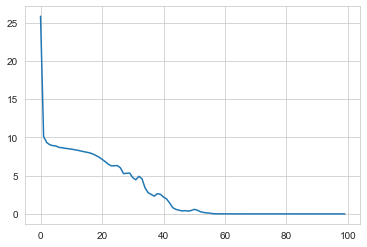

In [120]:
model = trainconvynet(device='cuda', num_epochs=100, dataset=datasets['10000'][1], BATCH_SIZE=500, lr_start=0.005, lr_end=0.001)

In [140]:
dataloader = DataLoader(datasets['10000'][7], batch_size=100)
ypred1 = 0
ypred0 = 0
for batch in dataloader:
    image = batch['image'].to(device)
    x = batch['X'].to(device)
    ypred1 += torch.sigmoid(model(image,x,torch.ones(x.shape[0],1).to(device))).sum()
    ypred0 += torch.sigmoid(model(image,x,torch.zeros(x.shape[0],1).to(device))).sum()

In [141]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.58652421875 0.42505712890625


In [119]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.59977119140625 0.3825359375


In [114]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.591882177734375 0.399739306640625


In [103]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.597430810546875 0.46091552734375


In [57]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.511830078125 0.499857275390625


In [50]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.567388330078125 0.43657685546875


In [45]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.52880625 0.500717578125


In [43]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.514737060546875 0.51340390625


In [162]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.597767333984375 0.375964453125


In [160]:
direct_pydot1 = ypred1.sum().item() / 10000
direct_pydot0 = ypred0.sum().item() / 10000
print(direct_pydot1,direct_pydot0)

0.59549189453125 0.372677587890625


## Get p(y|t)

In [94]:
df = dfs['10000'][0]
pyt1 = df['y'][df['t']==1].mean()
pyt0 = df['y'][df['t']==0].mean()
print(pyt1, pyt0)

0.683311 0.26636904


## Plot convergence

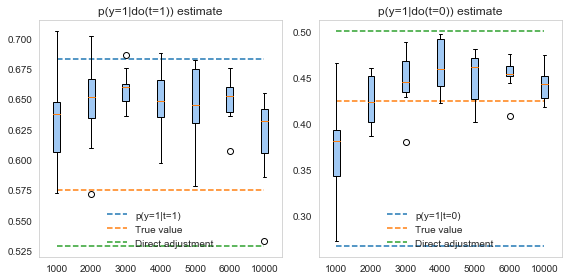

In [47]:
import seaborn as sns
from matplotlib.patches import Patch
fig, ax = plt.subplots(1,2,figsize=(8,4))
places = list(range(len(labels)))
width = 0.2
palette = sns.color_palette("pastel")
ax[0].plot([places[0],places[-1]],[pyt1,pyt1],'--')
ax[1].plot([places[0],places[-1]],[pyt0,pyt0],'--')
ax[0].plot([places[0],places[-1]],[p_y_dot1_true,p_y_dot1_true],'--')
ax[1].plot([places[0],places[-1]],[p_y_dot0_true,p_y_dot0_true],'--')
ax[0].plot([places[0],places[-1]],[direct_pydot1,direct_pydot1],'--')
ax[1].plot([places[0],places[-1]],[direct_pydot0,direct_pydot0],'--')
ax[0].legend(["p(y=1|t=1)","True value","Direct adjustment"], frameon=False)
ax[1].legend(["p(y=1|t=0)","True value","Direct adjustment"], frameon=False)
ax[0].set_title("p(y=1|do(t=1)) estimate")
ax[1].set_title("p(y=1|do(t=0)) estimate")

for k,pydot in enumerate([py_dot1,py_dot0]):
    for i in range(len(labels)):
        bplot = ax[k].boxplot(pydot[:,i], positions=[places[i]], widths=[width], patch_artist=True)
        color = palette[0]
        for patch in bplot['boxes']:
            patch.set_facecolor(color)
    ax[k].set_xticks(places)
    ax[k].set_xticklabels(datasize)
    ax[k].grid(False)
    #custom_line = Patch(facecolor=palette[0], edgecolor='black')

plt.tight_layout()
plt.savefig("Figures/publication/imagedata_convergence.png", bbox_inches = 'tight', pad_inches = 0.1)
plt.show()